In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
 df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [4]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [5]:
df.columns = ['Month','Milk in pounds per cow']

In [6]:
df.head()

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [7]:
df.drop(168, axis = 0,inplace = True)

In [8]:
df['Month'] = pd.to_datetime(df['Month'])

In [9]:
df.set_index('Month',inplace = True)

In [10]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in pounds per cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


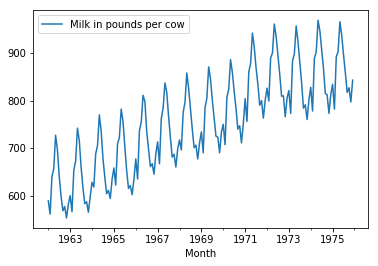

In [12]:
df.plot()

In [13]:
time_series = df['Milk in pounds per cow']

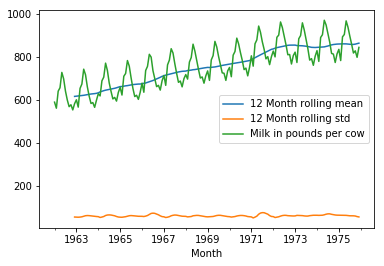

In [14]:
time_series.rolling(12).mean().plot(label = '12 Month rolling mean')
time_series.rolling(12).std().plot(label = '12 Month rolling std')
time_series.plot()
plt.legend();

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
decomp = seasonal_decompose(time_series)

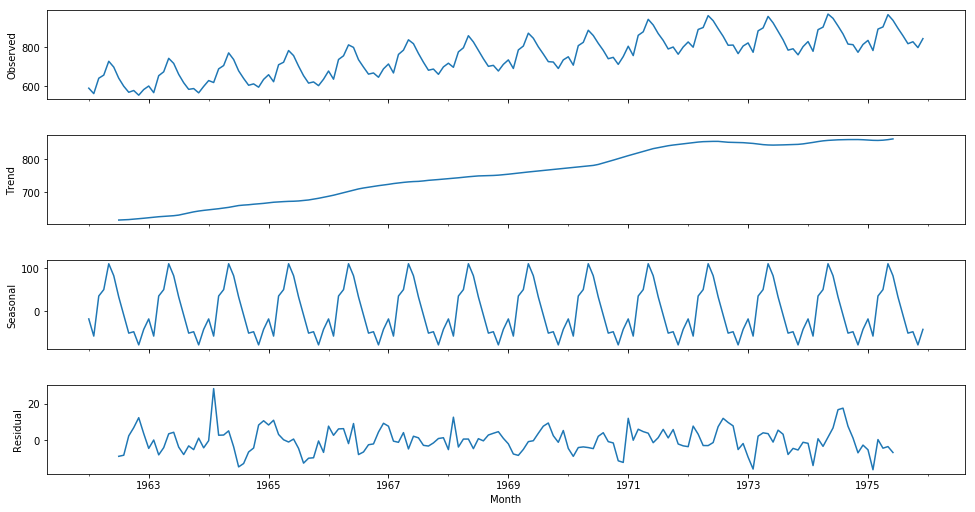

In [17]:
fig = decomp.plot()
fig.set_size_inches(15,8)

In [18]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
result = adfuller(df['Milk in pounds per cow'])

In [21]:
def adf_check(time_series):
    result = adfuller(time_series)
    print(" Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic','p-value','# of lags','Num of Observations used']
    for value,label in zip(result,labels):
        print(label,':',str(value))
    #Determine by p-value
    if result[1] <= 0.05:
        print("Strong evidence againts null hypothesis")
        print("reject null hypothesis")
        print("Data has no unit root is stationary")
    else:
        print("Weak evidence againts null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has unit root, it is non stationary")

In [22]:
adf_check(df['Milk in pounds per cow'])

 Augmented Dicky-Fuller Test
ADF Test Statistic : -1.3038115874221294
p-value : 0.6274267086030316
# of lags : 13
Num of Observations used : 154
Weak evidence againts null hypothesis
Fail to reject null hypothesis
Data has unit root, it is non stationary


In [23]:
#Stationarised
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

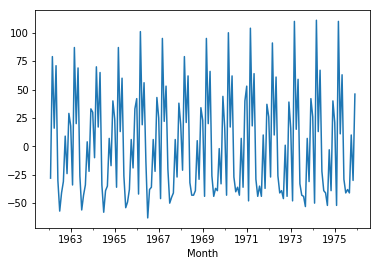

In [24]:
df['Milk First Difference'].plot()

In [25]:
df['Milk Second Difference']=df['Milk First Difference']-df['Milk First Difference'].shift(1)

In [26]:
adf_check(df['Milk Second Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic : -14.327873645603301
p-value : 1.1126989332084581e-26
# of lags : 11
Num of Observations used : 154
Strong evidence againts null hypothesis
reject null hypothesis
Data has no unit root is stationary


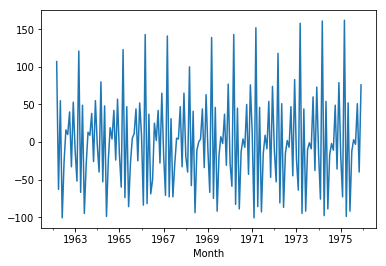

In [27]:
df['Milk Second Difference'].plot()

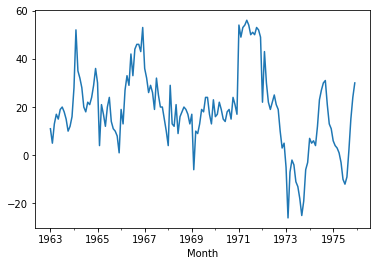

In [28]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
df['Seasonal Difference'].plot()

In [29]:
adf_check(df['Seasonal Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
# of lags : 12
Num of Observations used : 143
Weak evidence againts null hypothesis
Fail to reject null hypothesis
Data has unit root, it is non stationary


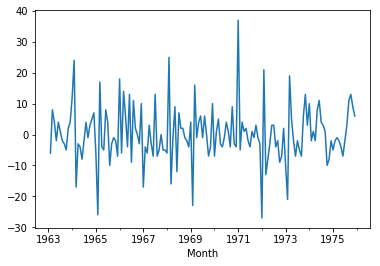

In [30]:
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [31]:
adf_check(df['Seasonal First Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic : -5.038002274921984
p-value : 1.8654234318788342e-05
# of lags : 11
Num of Observations used : 143
Strong evidence againts null hypothesis
reject null hypothesis
Data has no unit root is stationary


In [32]:
from statsmodels.graphics.tsaplots  import plot_acf,plot_pacf

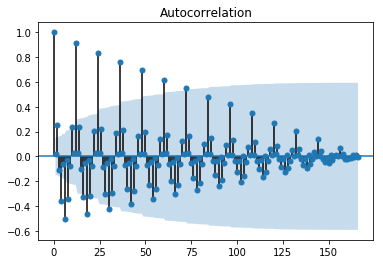

In [33]:
fig_first = plot_acf(df['Milk First Difference'].dropna())

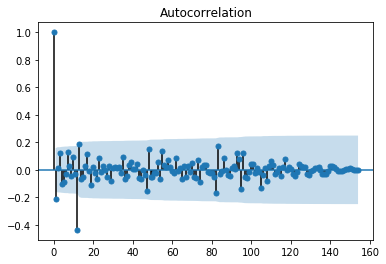

In [34]:
fig_first = plot_acf(df['Seasonal First Difference'].dropna())

In [35]:
from pandas.plotting import autocorrelation_plot

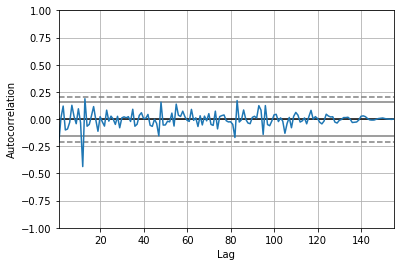

In [36]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

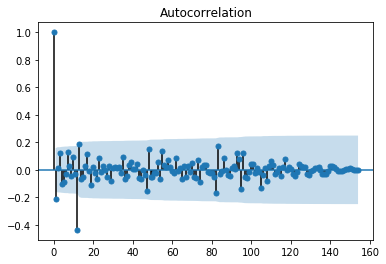

In [37]:
fig_first = plot_acf(df['Seasonal First Difference'].dropna())

In [38]:
from statsmodels.tsa.arima_model import ARIMA

In [39]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

In [40]:
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(0,1,0), seasonal_order=(1,1,1,12))

C:\Users\Nattapong\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [41]:
results = model.fit()

In [42]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Thu, 17 Jan 2019   AIC                           1074.131
Time:                                    22:37:28   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

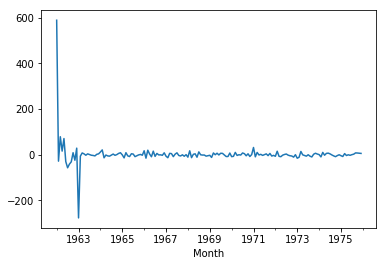

In [43]:
results.resid.plot()

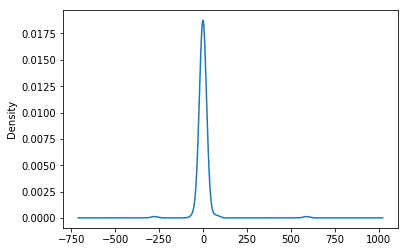

In [44]:
results.resid.plot(kind = 'kde')

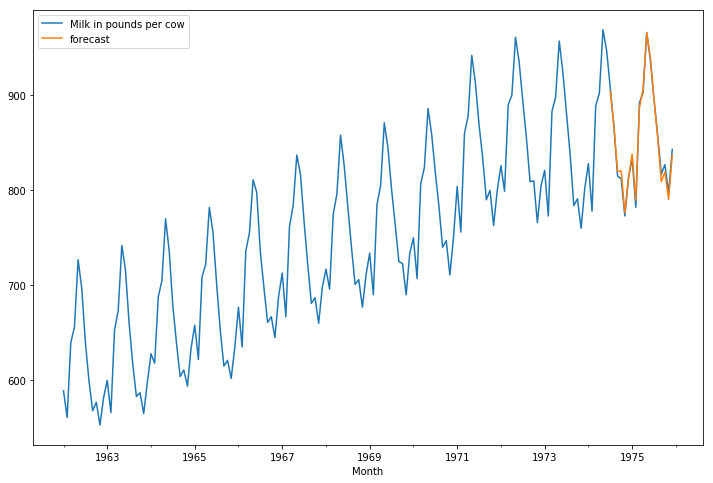

In [45]:
df['forecast'] = results.predict(start=150,end=168)
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

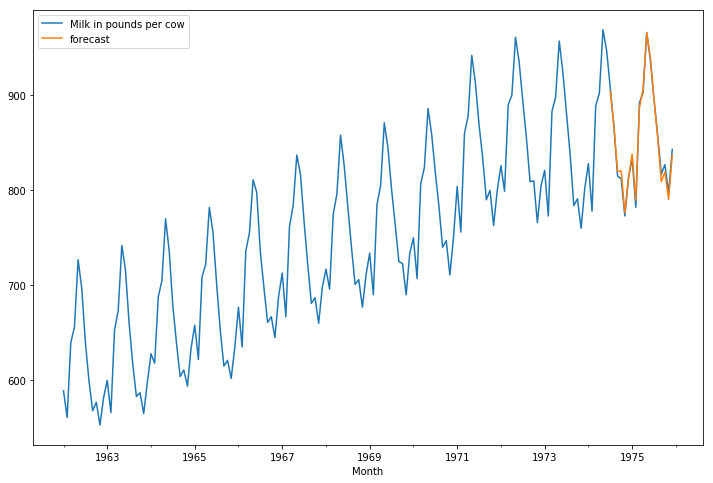

In [46]:
#Add number on end value is not gonna work
df['forecast'] = results.predict(start=150,end=250)
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

In [47]:
df.tail()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,855.358648
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,808.841372
1975-10-01,827.0,10.0,51.0,15.0,13.0,819.323185
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,790.427530
1975-12-01,843.0,46.0,76.0,30.0,6.0,837.063622


In [48]:
from pandas.tseries.offsets import DateOffset

In [49]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24)]

In [50]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [51]:
future_df = pd.DataFrame(index = future_dates,columns=df.columns)

In [52]:
future_df

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1975-12-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
final_df = pd.concat([df,future_df],axis = 0)

In [55]:
final_df

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN,NaN
1962-03-01,640.0,79.0,107.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,-63.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,55.0,NaN,NaN,NaN
1962-06-01,697.0,-30.0,-101.0,NaN,NaN,NaN
1962-07-01,640.0,-57.0,-27.0,NaN,NaN,NaN
1962-08-01,599.0,-41.0,16.0,NaN,NaN,NaN
1962-09-01,568.0,-31.0,10.0,NaN,NaN,NaN
1962-10-01,577.0,9.0,40.0,NaN,NaN,NaN


In [56]:
final_df['forecast'] = results.predict(start=168,end=192)


In [57]:
final_df.tail()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,NaN,911.918957
1977-09-01,NaN,NaN,NaN,NaN,NaN,865.881182
1977-10-01,NaN,NaN,NaN,NaN,NaN,871.027296
1977-11-01,NaN,NaN,NaN,NaN,NaN,836.962997


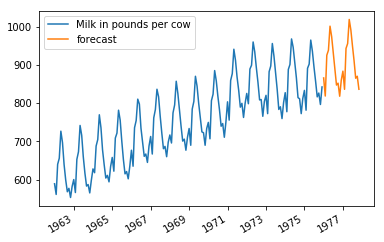

In [58]:
final_df[['Milk in pounds per cow','forecast']].plot()